In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xlrd
import pandas as pd
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']

In [2]:
def get_data(Path):
    '''
    获取数据
    :param Path:   文件的路径及文件名
    :return:       返回平均绝对误差最小的平滑系数和最小平均绝对误差
    '''
    book = xlrd.open_workbook(Path)  #打开excel
    sheet = book.sheet_by_index(0)  #根据sheet页名字获取sheet
    data_col = sheet.ncols #获取excel里面有多少列
    data_row = sheet.nrows #获取excel里面有多少行
    time = []
    actual_values = []
    factor_names = []
    factor_values = []
    for i in range(1,data_row):
        time.append(int(sheet.col_values(0)[i]))
        actual_values.append(sheet.col_values(1)[i])
    actual_name = sheet.col_values(1)[0]

    if data_col >= 3:
        for i in range(2,data_col):
            factor = []
            for j in range(1,data_row):
                factor.append(sheet.col_values(i)[j])
            factor_values.append(factor)
            factor_names.append(sheet.col_values(i)[0])

    return time, actual_name, actual_values, factor_names, factor_values

In [3]:
def chart(name, data, F, t):
    '''
    绘制散点图
    :param name:  变量名：str
    :param data:  原始类型：list
    :param F:     预测序列：list
    :param t:     时间类型：list
    '''
    print("----"*10+'比较分析图'+"----"*10)
    F = F
    data = data
    t = t
    plt.title("预测比较图",fontsize=20)  #图表名称
    plt.xlabel("年份", fontsize=12)  #改x坐标轴标题
    plt.ylabel(name, fontsize=12)  #改y坐标轴标题
    plt.scatter(t, data, label='实际值',s=10)
    plt.scatter(t, F, marker = 'x', label='预测值',s=10)
    plt.plot(t, data)
    plt.plot(t, F)
    plt.legend()
    plt.savefig('折线图.png', bbox_inches='tight',dpi = 300)
    plt.show()

In [4]:
def examine(x0,f0):
    '''
    GM(1,1)灰色模型检验
    :param x0:   原始序列：list
    :param f0:   时间序列：list
    :return:     
    '''
    print("----"*10+'模型检验'+"----"*10)
    delta = x0 - f0  # 残差序列
    print("残差序列为")
    print(delta)
    C = delta.std()/x0.std() # 后验比差值，np.std()标准差，np.var()方差
    P = 1.0*(np.abs(delta - delta.mean()) < 0.6745*x0.std()).sum()/len(x0)
    print("后验比差值C=", C, "小残差概率P=", P)
    if (C < 0.35 and P > 0.95): # 评测后验差判别
        print('该模型精度为---好')
    elif (C < 0.5 and P > 0.8):
        print('该模型精度为---合格')
    elif (C < 0.65 and P > 0.7):
        print('该模型精度为---勉强合格')
    else:
        print('该模型精度为--不合格')

In [5]:
def gm11(name,data,time,k=5):
    '''
    GM(1,1)灰色模型建模
    :param name:   变量名：str
    :param data:   原始序列：list
    :param data:   时间序列：list
    :param n:      预测期数：num
    :return:       返回平均绝对误差最小的平滑系数和最小平均绝对误差
    '''
    n = len(data)
    x0 = np.array(data)
    print("----"*10+'数据处理'+"----"*10)
    print("初始序列为")
    print(x0)

    x1 = x0.cumsum() #1-AGO序列
    print("累加序列为")
    print(x1)
    
    z1 = (x1[:len(x1)-1] + x1[1:])/2.0  #紧邻均值（MEAN）生成序列
    print("紧邻均值生成序列为")
    print(z1)

    print("----"*10+'构建矩阵B和Yn'+"----"*9)
    z1 = z1.reshape((len(z1),1))
    B = np.append(-z1, np.ones_like(z1), axis = 1)
    print("数据矩阵B为")
    print(B)
    
    Yn = x0[1:].reshape((len(x0)-1, 1))
    print("数据矩阵Yn为")
    print(Yn)
    
    print("----"*10+'求解参数'+"----"*10)
    [[a],[b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Yn) #计算参数
    print("待估参数向量为")
    print([[a],[b]])
    print("即a=", a,", b=", b)
    
    print("----"*10+'预测模型'+"----"*10)
    print("预测模型为: f(k+1)=", x0[0]-b/a, "×(1-e^{})×e^{}k".format(a,-a))
    
    f0 = np.zeros(n)
    for i in range(n):
        f0[i] = (x0[0] - b/a)*(1-np.exp(a))*np.exp(-a*(i))
    print("预测序列为")
    print(f0)
    
    examine(x0,f0)
    chart(name, x0, f0, time)
    
    print("----"*10+'预测结果'+"----"*10)
    f1 = np.zeros(k)
    for i in range(n, n+k):
        f1[i-n] = (x0[0] - b/a)*(1-np.exp(a))*np.exp(-a*(i))
    print("利用模型向后预测{}期，预测结果为".format(k))
    print(f1)

In [6]:
def GRA(x, y, x_name, y_name,rho=0.5):
    #
    '''
    GM(1,1)灰色模型建模
    :param x:       原始序列：list
    :param y:       对比序列：list
    :param x_name:  变量名：str
    :param y_name:  变量名：str
    :param rho:     分辨系数,一般取0.5
    :return:        返回灰色关联度
    '''
    data = []
    data.append(x)
    for i in y:
        data.append(i)
    data = pd.DataFrame(data)
    data = data.iloc[:,0:]

    # 1、数据均值化处理
    data_mean=data.mean(axis=1)
    for i in range(data.index.size):
        data.iloc[i,:] = data.iloc[i,:]/data_mean[i]
    
    # 2、提取参考队列和比较队列
    reference=data.iloc[0,:]
    contrast=data.iloc[1:,:]
    
    # 比较队列与参考队列相减
    t=pd.DataFrame()
    for j in range(contrast.index.size):
        temp=pd.Series(contrast.iloc[j,:]-reference)
        t=t.append(temp,ignore_index=True)
    
    #求最大差和最小差
    mmax=t.abs().max().max()
    mmin=t.abs().min().min()
    rho=0.5  #分辨系数,一般取0.5
    
    #3、求关联系数
    ksi=((mmin+rho*mmax)/(abs(t)+rho*mmax))
    
    #4、求关联度
    r=ksi.sum(axis=1)/ksi.columns.size
    
    print("----"*9+'灰色关联度分析'+"----"*10)
    for i in range(len(y_name)):
        print(y_name[i],"与{}之间的的灰色关联度为".format(x_name),r[i])
    return r


------------------------------------灰色关联度分析----------------------------------------
社会消费品零售总额(亿元) 与晋江机场货邮吞吐量(吨)之间的的灰色关联度为 0.8321287314290979
地区生产总值(亿元) 与晋江机场货邮吞吐量(吨)之间的的灰色关联度为 0.8816149447327358
茶叶产量(万吨) 与晋江机场货邮吞吐量(吨)之间的的灰色关联度为 0.6321091840714352
生物医药销售产值(亿元) 与晋江机场货邮吞吐量(吨)之间的的灰色关联度为 0.7003587717954797
纺织鞋服销售产值(亿元) 与晋江机场货邮吞吐量(吨)之间的的灰色关联度为 0.8492667754172439
工业增加值(亿元) 与晋江机场货邮吞吐量(吨)之间的的灰色关联度为 0.7721964618533301
常住人口(万人) 与晋江机场货邮吞吐量(吨)之间的的灰色关联度为 0.5431643372032279
----------------------------------------数据处理----------------------------------------
初始序列为
[22938.   31227.   35711.   38772.   41233.   43033.32 49683.37 59277.79
 63845.42 75294.59]
累加序列为
[ 22938.    54165.    89876.   128648.   169881.   212914.32 262597.69
 321875.48 385720.9  461015.49]
紧邻均值生成序列为
[ 38551.5    72020.5   109262.    149264.5   191397.66  237756.005
 292236.585 353798.19  423368.195]
----------------------------------------构建矩阵B和Yn------------------------------------
数据矩阵B为
[[-3.85515000e+04  1.00000000e+00]
 [-7

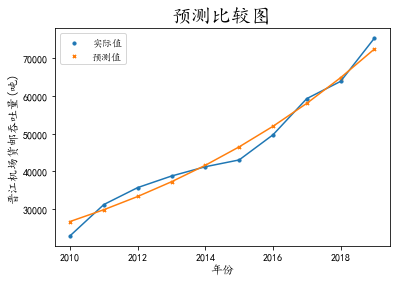

----------------------------------------预测结果----------------------------------------
利用模型向后预测5期，预测结果为
[ 80895.09919693  90369.82318607 100954.26081128 112778.38571143
 125987.39450385]


In [7]:
time, actual_name, actual_values, factor_names, factor_values = get_data('data.xlsx')
GRA(actual_values,factor_values, actual_name, factor_names)
gm11(actual_name,actual_values,time)